In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
from collections import OrderedDict, Counter
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")
import os
import sys
sys.path.insert(0, '../../src')
from utils import ProcessData
from starlette.config import Config

import unicodedata
from tqdm import tqdm
import re
import io
import msoffcrypto

from googletrans import Translator
import googlemaps

translator = Translator()
config = Config("../../../../../.env")
pw = config("HASEKO_DATA_PW", cast=str)
# google_api_key = config("HASEKO_GOOGLE_API_KEY", cast=str)
# gmaps = googlemaps.Client(key=google_api_key)

%matplotlib inline

In [2]:
def get_boundaries(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def remove_outliers(df, column):
    lower_bound, upper_bound = get_boundaries(df, column)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def reverse_transform(X, tr):
    for name, transfo in enumerate(list(tr[0])):
        if transfo =='Squared':
            X = np.squeeze(np.square(X))
        elif transfo == 'Log':
            X = np.squeeze(np.expm1(X))
        else:
            X = np.squeeze(X)
    return X

def normalization(data,method):
    if method == 'mean':
        # Mean normalization
        x, y = data.mean(), data.std()
        data = (data-x)/y
    elif method == 'minmax':
        # Min-max normalization
        x, y = data.min(), data.max()
        data = (data-x)/(y-x)
    return data, (x.values[0],y.values[0])

def unskew_data(data):
    def process_data(data, idx):
        d = {}
        for i in data.columns:
            method = idx.loc[i,0]
            if method == 'Log':
                d[i] = np.log1p(data[i])
            elif method == 'Squared':
                d[i] = np.sqrt(data[i])
            else:
                d[i] = data[i]
        data_pr = pd.DataFrame(data=d, columns = data.columns)
        data_pr = data_pr.fillna(data_pr.mean())
        return data_pr
    
    data = data.astype(float)

    data_log = pd.DataFrame(np.log1p(data), columns= data.columns)
    data_square = pd.DataFrame(np.sqrt(data), columns= data.columns)

    data_skewness = pd.concat([data.skew(), data_log.skew(), data_square.skew()], axis=1)
    data_skewness.columns = ['Raw','Log','Squared']
    data_min = data_skewness.abs().idxmin(axis=1).to_frame()
    data_unskewed = process_data(data, data_min)
    
    return data_unskewed, data_min

# New training data

In [3]:
area = {'1100': 'Saitama',
        '1200': 'Chiba',
        '1301': 'Central Tokyo',
        '1302': 'Western Tokyo',
        '1303': 'Eastern Tokyo',
        '1304': 'Tokyo city',
        '1400': 'Kanagawa'}

new_dict = ['年齢\nage','合算後年収.1\nAnnual income after the sum .1', '家族数\nFamily number',
            '家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)', '面積\narea','LP名\nLP name',
            '最新住所\nLatest address']

# Previous training data

In [4]:
pws_dict = {'age':'年齢\nage',
            'income':'合算後年収.1\nAnnual income after the sum .1',
            'family_members':'家族数\nFamily number',
            'mf_family_type_str':'家族F\nFamily F',
            'price':'物件価格(千円)\nProperty price (1,000 yen)',
            'width':'面積\narea',
            'name':'LP名\nLP name',
            'pref_code':'pref_code',
            'pref_name':'pref_name',
            'city_code':'city_code',
            'city_name':'city_name',
            'area_code':'area_code',
            'area_name':'area_name',
            'search_area_code':'search_area_code',
            'search_area_name':'search_area_name',
            'lon':'lon',
            'lat':'lat'}

In [5]:
base_params = '../../src/params'
base_data = '../../haseko_v0/data/mansionfit_2020-12-02.csv'

data = ProcessData()
params_ml, _, area_data = data.load_json_file(base_params)
pws, _, _ = data.create_user_buildings_df(base_data, area_data)
pws = pws.dropna(axis=0)
pws['family_members'] = pws['family_members'].astype(int)
pws['income'] /= 1000000
pws['price'] /= 10000
# pws = pws[pws_dict.keys()]
# pws.columns = pws_dict.values()
# print(pws.shape)
# col = ['家族数\nFamily number','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)','面積\narea','LP名\nLP name','pref_code','pref_name','city_code','city_name','area_code','area_name','search_area_code','search_area_name','lon','lat']
# pws = pws.drop_duplicates(subset=col, keep=False, inplace=False)

print(pws.shape)
pws.head(1)

(5487, 54)


id_x  user_id        building_id    price  width floor_plan  \
0  31110031-3058098-01  3058098  31110031-31110031  5589.91  70.56       3LDK   

    age  income  family_members  kids_members  current_rent  home_pref_code  \
0  53.0    15.0               5           3.0      180000.0            13.0   

  home_pref_name  home_city_code home_city_name  home_area_code  \
0            東京都         13117.0             北区          1303.0   

  home_area_name  home_search_area_code home_search_area_name  \
0           東京東部                 1303.0             東京23区東エリア   

   office_pref_code office_pref_name  office_city_code office_city_name  \
0              13.0              東京都           13104.0              新宿区   

   office_area_code office_area_name  office_search_area_code  \
0            1301.0             東京中央                   1301.0   

  office_search_area_name  mf_price_type  mf_age_type  mf_income_type  \
0              東京23区中央エリア           5000         45.0            1500   

   mf_family_type  mf_floor_plan_type mf_price_type_str mf_age_type_str  \
0               2                 4.0            5000万台           45歳以上   

  mf_income_type_str mf_family_type_str mf_floor_plan_type_str  \
0             1500万〜           パートナーと子供                   3LDK   

                id_y         name  pref_code pref_name  city_code city_name  \
0  31110031-31110031  ザ・ガーデンズ東京王子         13       東京都      13117        北区   

   area_code area_name  search_area_code search_area_name         lon  \
0       1303      東京東部              1303        東京23区東エリア  139.726858   

         lat  station_line_code  station_code  station_lon  station_lat mf_id  
0  35.763803            11332.0     1133211.0    35.763803   139.726858   a-1

In [6]:
col = ['price','age','income','family_members','kids_members','current_rent','home_pref_code','home_pref_name','home_city_code','home_city_name','mf_family_type_str','mf_floor_plan_type_str','pref_code','pref_name','city_code','city_name']
ward_23 = ['千代田区', '中央区', '港区', '新宿区', '文京区', '台東区', '墨田区', '江東区', '品川区', '目黒区', '大田区', '世田谷区', '渋谷区', '中野区', '杉並区', '豊島区', '北区', '荒川区', '板橋区', '練馬区', '足立区', '葛飾区', '江戸川区']

pws = pws[col]
pws['living_area'] = pws['home_pref_name']
pws['living_area_details'] = [i if j not in ward_23 else i+'_23' for i,j in zip(pws['home_pref_name'], pws['home_city_name'])]
pws['moving_area'] = pws['pref_name']
pws['moving_area_details'] = [i if j not in ward_23 else i+'_23' for i,j in zip(pws['pref_name'], pws['city_name'])]

pws.head(1)

price   age  income  family_members  kids_members  current_rent  \
0  5589.91  53.0    15.0               5           3.0      180000.0   

   home_pref_code home_pref_name  home_city_code home_city_name  \
0            13.0            東京都         13117.0             北区   

  mf_family_type_str mf_floor_plan_type_str  pref_code pref_name  city_code  \
0           パートナーと子供                   3LDK         13       東京都      13117   

  city_name living_area living_area_details moving_area moving_area_details  
0        北区         東京都              東京都_23         東京都              東京都_23

In [7]:
df = pws.copy()
family_type_mapping = {family: i for i, family in enumerate(df['mf_family_type_str'].unique())}
living_area_mapping = {area: i+len(family_type_mapping) for i, area in enumerate(df['living_area'].unique())}
moving_area_mapping = {area: i+len(family_type_mapping)+len(living_area_mapping) for i, area in enumerate(df['moving_area'].unique())}

# Create lists to define the source, target, and value flows
sources = []
targets = []
values = []

for _, row in df.iterrows():
    # Add flow from family type to living area
    sources.append(family_type_mapping[row['mf_family_type_str']])
    targets.append(living_area_mapping[row['living_area']])
    values.append(row['income'])
    
    # Add flow from living area to moving area
    sources.append(living_area_mapping[row['living_area']])
    targets.append(moving_area_mapping[row['moving_area']])
    values.append(row['income'])

# Define node labels
labels = list(family_type_mapping.keys()) + list(living_area_mapping.keys()) + list(moving_area_mapping.keys())

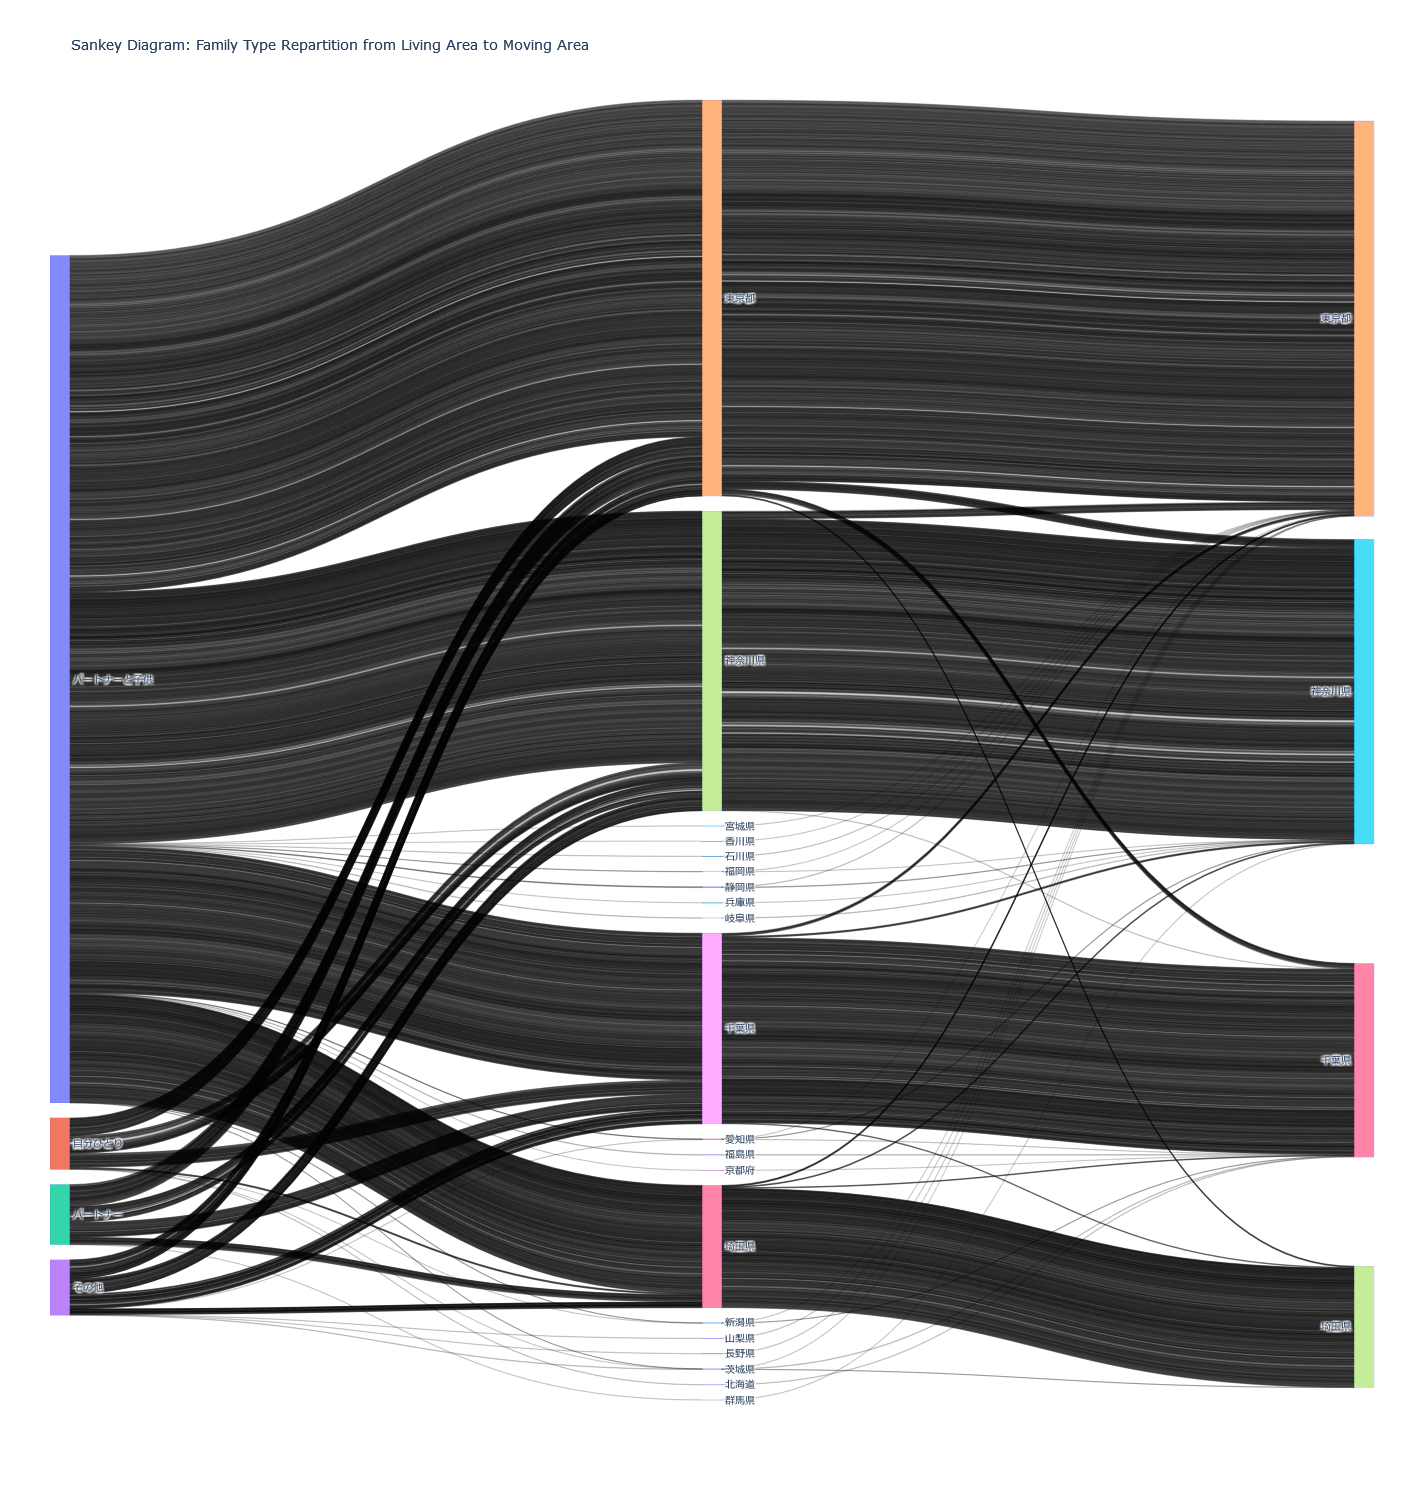

In [8]:
layout = go.Layout(autosize=False, width=1250, height=1500,
                   xaxis=go.layout.XAxis(linecolor="blue", linewidth=1, mirror=True),
                   yaxis=go.layout.YAxis(linecolor="blue", linewidth=1, mirror=True),
                   margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),)

fig = go.Figure(data=[go.Sankey(node=dict(pad=15,thickness=20,line=dict(color="blue", width=0.1),label=labels),
                      link=dict(source=sources,target=targets,value=values))],
                layout=layout)

fig.update_layout(title_text="Sankey Diagram: Family Type Repartition from Living Area to Moving Area", font_size=10)
fig.show()

In [20]:
df = pws.copy()
family_type_mapping = {family: i for i, family in enumerate(df['mf_family_type_str'].unique())}
living_area_mapping = {area: i+len(family_type_mapping) for i, area in enumerate(df['living_area_details'].unique())}
moving_area_mapping = {area: i+len(family_type_mapping)+len(living_area_mapping) for i, area in enumerate(df['moving_area_details'].unique())}

# Create lists to define the source, target, and value flows
sources = []
targets = []
values = []

for _, row in df.iterrows():
    # Add flow from family type to living area
    sources.append(family_type_mapping[row['mf_family_type_str']])
    targets.append(living_area_mapping[row['living_area_details']])
    values.append(row['income'])
    
    # Add flow from living area to moving area
    sources.append(living_area_mapping[row['living_area_details']])
    targets.append(moving_area_mapping[row['moving_area_details']])
    values.append(row['income'])

# Define node labels
labels = list(family_type_mapping.keys()) + list(living_area_mapping.keys()) + list(moving_area_mapping.keys())

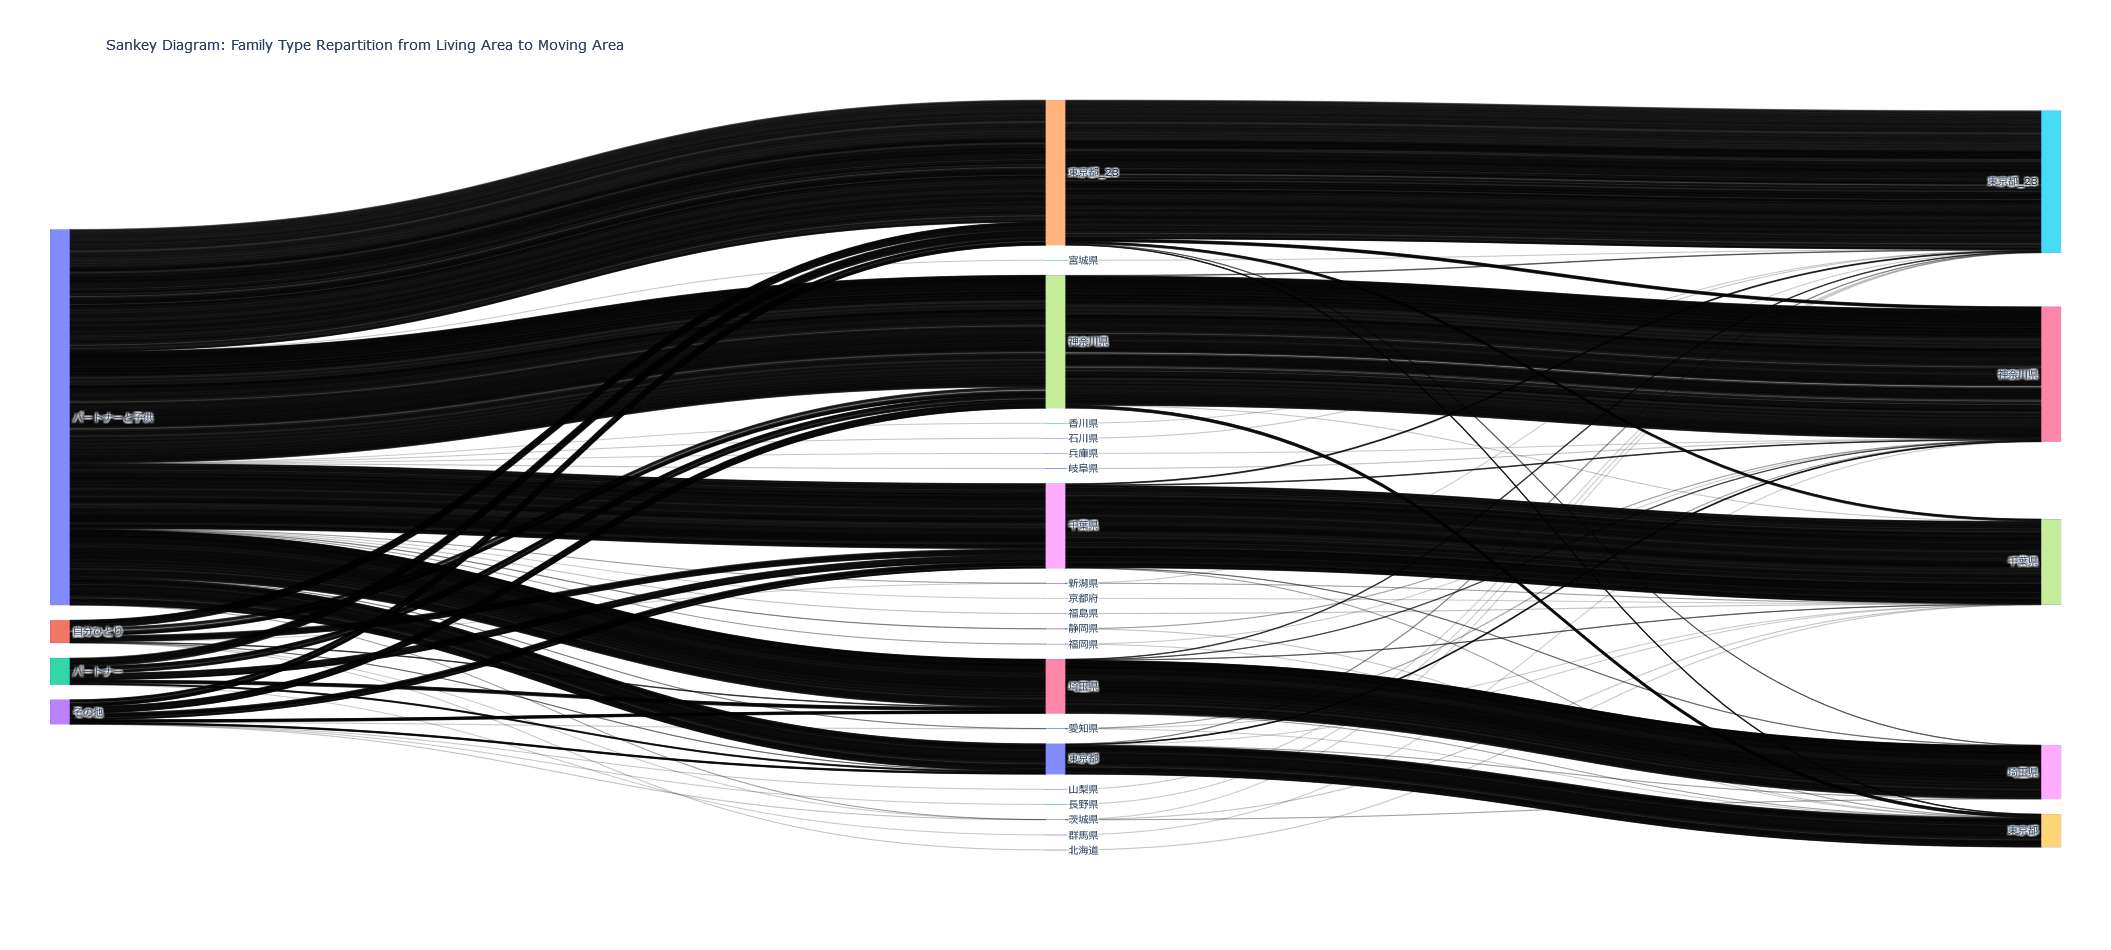

In [21]:
layout = go.Layout(autosize=False, width=1250, height=950,
                   xaxis=go.layout.XAxis(linecolor="blue", linewidth=1, mirror=True),
                   yaxis=go.layout.YAxis(linecolor="blue", linewidth=1, mirror=True),
                   margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),)

fig = go.Figure(data=[go.Sankey(node=dict(pad=15,thickness=20,line=dict(color="blue", width=0.1),label=labels),
                      link=dict(source=sources,target=targets,value=values))],
                layout=layout)

fig.update_layout(title_text="Sankey Diagram: Family Type Repartition from Living Area to Moving Area", font_size=10)
fig.show()

In [22]:
df = pws.copy()
df = df[df['home_pref_code']==13]
df = df[df['pref_code']==13]
family_type_mapping = {family: i for i, family in enumerate(df['mf_family_type_str'].unique())}
living_area_mapping = {area: i+len(family_type_mapping) for i, area in enumerate(df['home_city_name'].unique())}
moving_area_mapping = {area: i+len(family_type_mapping)+len(living_area_mapping) for i, area in enumerate(df['city_name'].unique())}

# Create lists to define the source, target, and value flows
sources = []
targets = []
values = []

for _, row in df.iterrows():
    # Add flow from family type to living area
    sources.append(family_type_mapping[row['mf_family_type_str']])
    targets.append(living_area_mapping[row['home_city_name']])
    values.append(row['income'])
    
    # Add flow from living area to moving area
    sources.append(living_area_mapping[row['home_city_name']])
    targets.append(moving_area_mapping[row['city_name']])
    values.append(row['income'])

# Define node labels
labels = list(family_type_mapping.keys()) + list(living_area_mapping.keys()) + list(moving_area_mapping.keys())

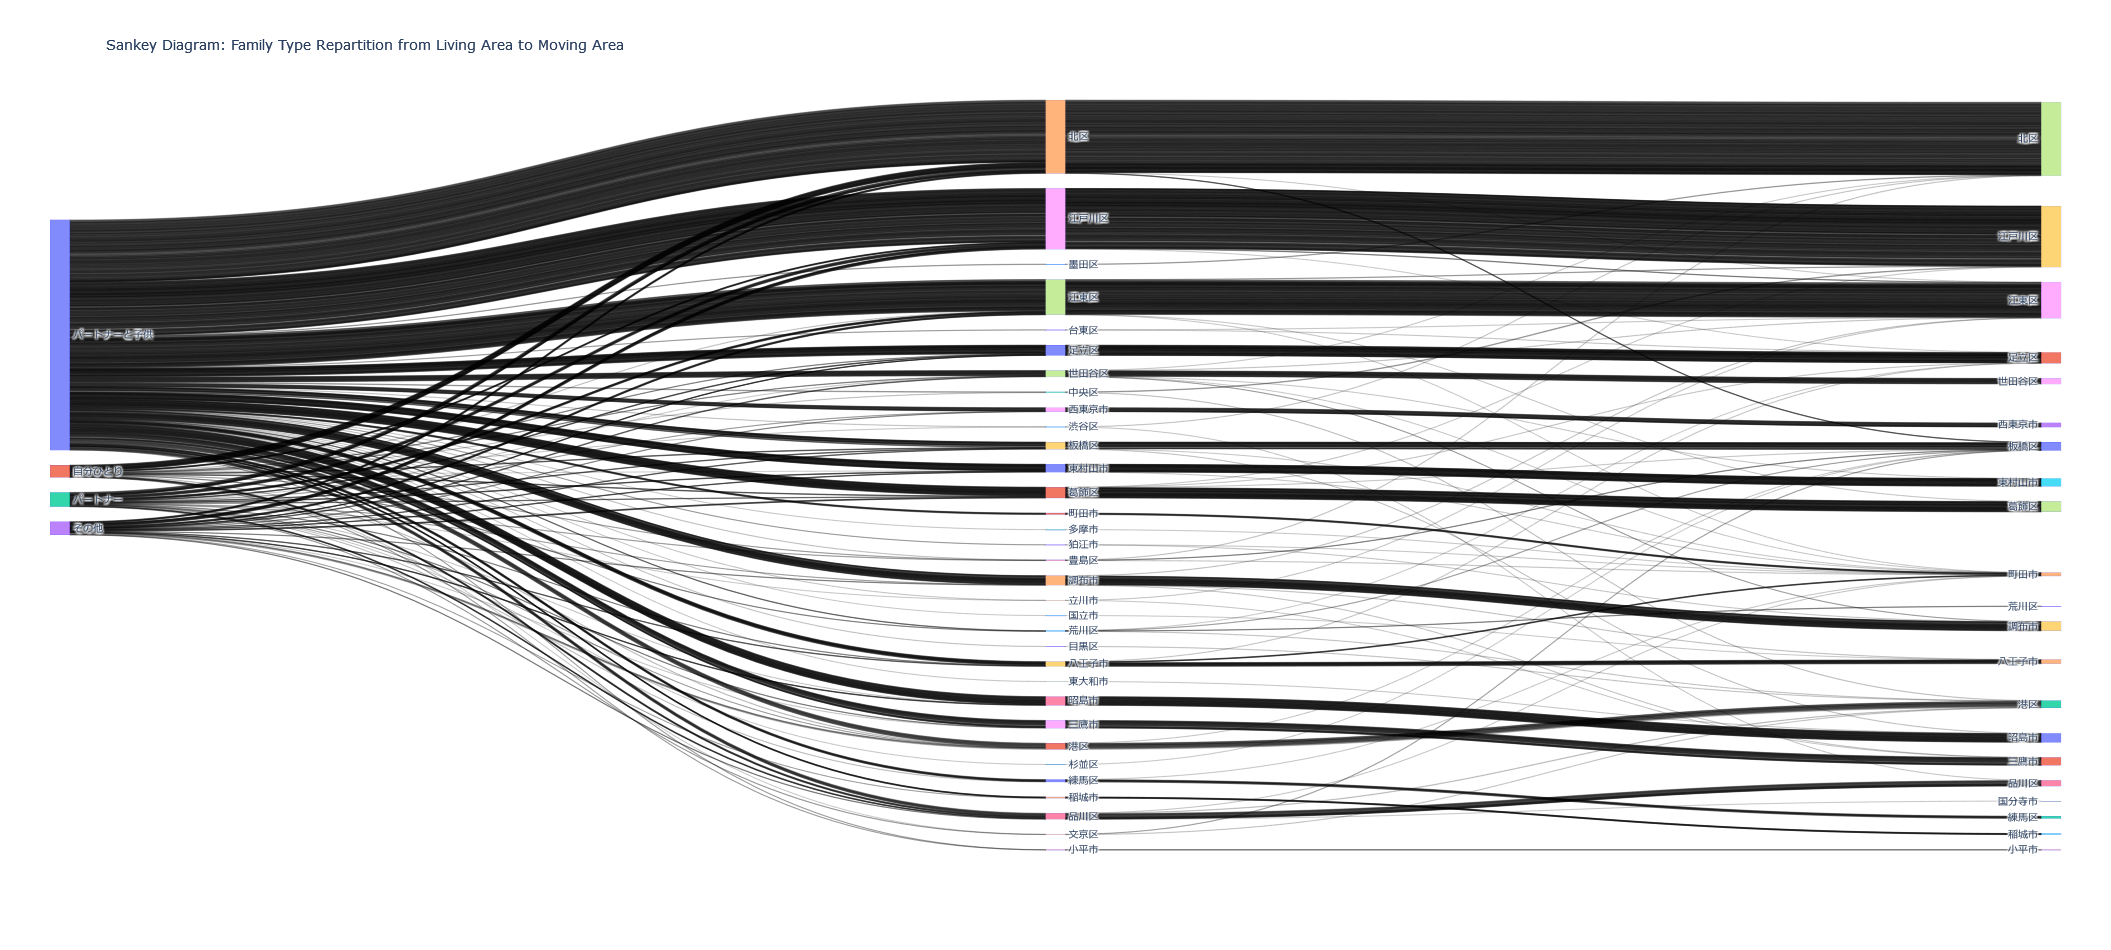

In [23]:
layout = go.Layout(autosize=False, width=1250, height=950,
                   xaxis=go.layout.XAxis(linecolor="blue", linewidth=1, mirror=True),
                   yaxis=go.layout.YAxis(linecolor="blue", linewidth=1, mirror=True),
                   margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),)

fig = go.Figure(data=[go.Sankey(node=dict(pad=15,thickness=20,line=dict(color="blue", width=0.1),label=labels),
                      link=dict(source=sources,target=targets,value=values))],
                layout=layout)

fig.update_layout(title_text="Sankey Diagram: Family Type Repartition from Living Area to Moving Area", font_size=10)
fig.show()

In [16]:
df = pws.copy()
df = df[df['living_area'] != df['moving_area']]
family_type_mapping = {family: i for i, family in enumerate(df['mf_family_type_str'].unique())}
living_area_mapping = {area: i+len(family_type_mapping) for i, area in enumerate(df['living_area'].unique())}
moving_area_mapping = {area: i+len(family_type_mapping)+len(living_area_mapping) for i, area in enumerate(df['moving_area'].unique())}

# Create lists to define the source, target, and value flows
sources = []
targets = []
values = []

for _, row in df.iterrows():
    # Add flow from family type to living area
    sources.append(family_type_mapping[row['mf_family_type_str']])
    targets.append(living_area_mapping[row['living_area']])
    values.append(row['income'])
    
    # Add flow from living area to moving area
    sources.append(living_area_mapping[row['living_area']])
    targets.append(moving_area_mapping[row['moving_area']])
    values.append(row['income'])

# Define node labels
labels = list(family_type_mapping.keys()) + list(living_area_mapping.keys()) + list(moving_area_mapping.keys())

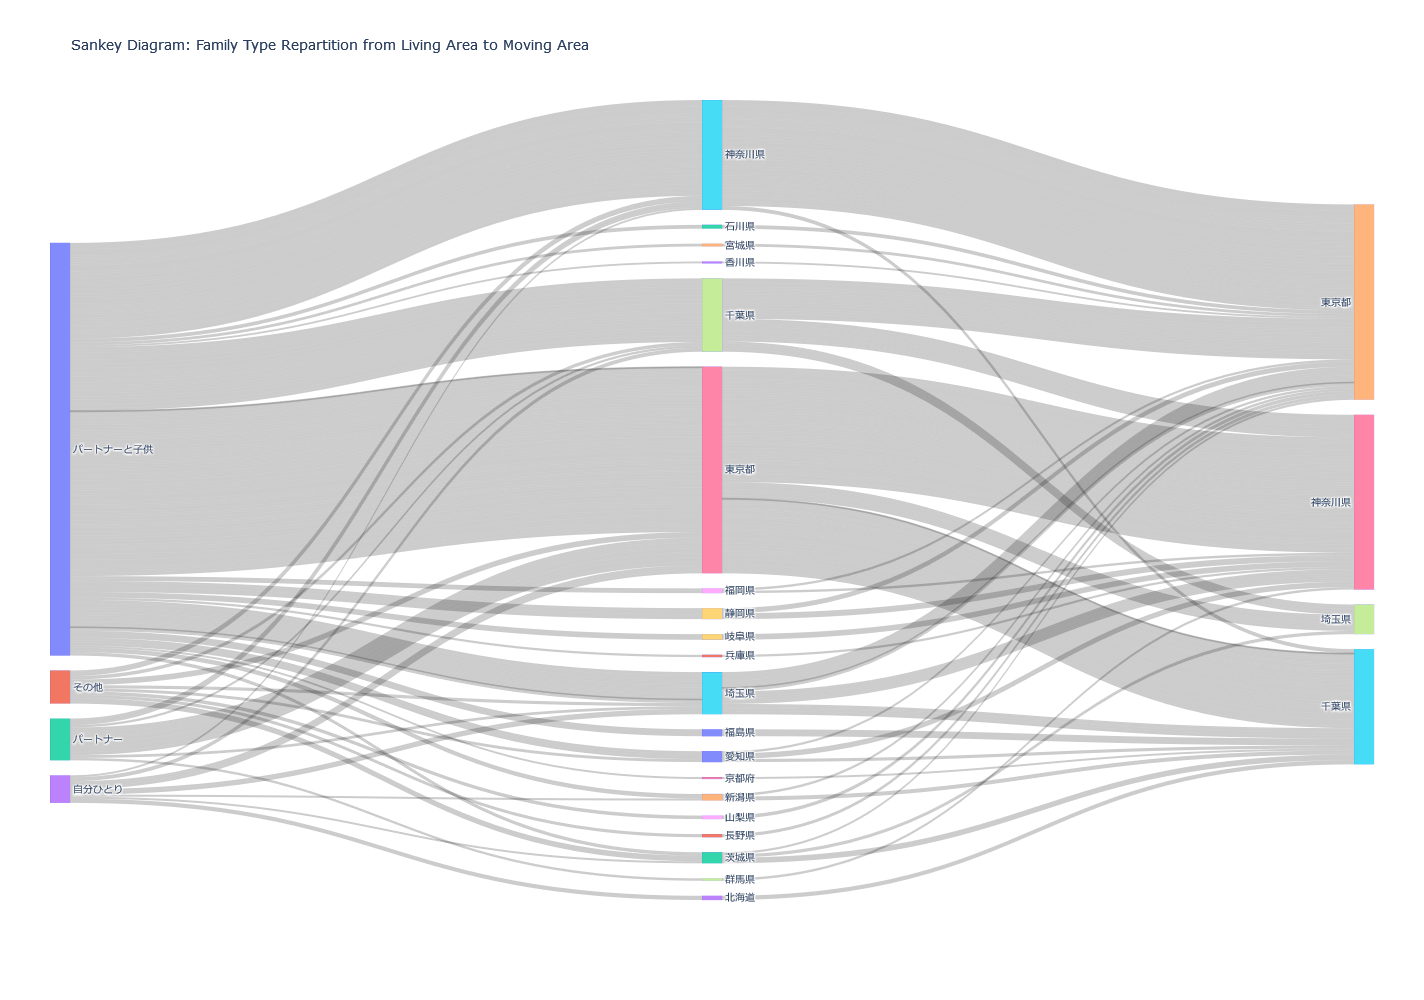

In [17]:
layout = go.Layout(autosize=False, width=1250, height=1000,
                   xaxis=go.layout.XAxis(linecolor="blue", linewidth=1, mirror=True),
                   yaxis=go.layout.YAxis(linecolor="blue", linewidth=1, mirror=True),
                   margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),)

fig = go.Figure(data=[go.Sankey(node=dict(pad=15,thickness=20,line=dict(color="blue", width=0.1), label=labels),
                      link=dict(source=sources, target=targets, value=values))],
                layout=layout)

fig.update_layout(title_text="Sankey Diagram: Family Type Repartition from Living Area to Moving Area", font_size=10)
fig.show()